In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = True
for layer in conv_base.layers[:-4]: # freeze all layers except last 4
    layer.trainable = False
conv_base.summary();

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)#(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [4]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'

In [5]:
import random

def load_data(train_img_dir, test_img_dir):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=64,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=0.2,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=64,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [6]:
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.


In [7]:
from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"{current_time}_fer_finetuning_vgg16.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

print(f'Saving model as: {current_time}_fer_finetuning_vgg16.keras')
history = model.fit(x=train_dataset, epochs=60, validation_data=val_dataset, callbacks=callbacks)

Saving model as: 20230707_12-31_fer_finetuning_vgg16.keras
Epoch 1/60
3596/3596 [==============================] - 625s 173ms/step - loss: 1.0338 - accuracy: 0.6541 - val_loss: 0.8374 - val_accuracy: 0.7129
Epoch 2/60
3596/3596 [==============================] - 616s 171ms/step - loss: 0.8037 - accuracy: 0.7237 - val_loss: 0.7816 - val_accuracy: 0.7318
Epoch 3/60
3596/3596 [==============================] - 616s 171ms/step - loss: 0.7273 - accuracy: 0.7495 - val_loss: 0.7826 - val_accuracy: 0.7345
Epoch 4/60
3596/3596 [==============================] - 615s 171ms/step - loss: 0.6533 - accuracy: 0.7747 - val_loss: 0.8327 - val_accuracy: 0.7307
Epoch 5/60
2583/3596 [====================>.........] - ETA: 2:16 - loss: 0.5743 - accuracy: 0.8006

KeyboardInterrupt: 

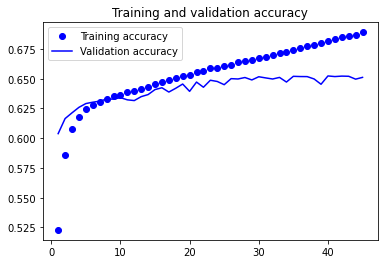

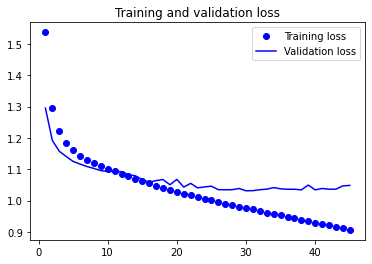

In [16]:
# complete dataset
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [8]:
# complete dataset
model = keras.models.load_model("20230707_12-31_fer_finetuning_vgg16.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 10s 157ms/step - loss: 2.0137 - accuracy: 0.3966
Test accuracy: 0.397
